# Using our VQA system

In [1]:
!pip install torchvision

이 코드는 PyTorch와 Transformers 라이브러리를 사용하여 이미지와 텍스트 처리를 위한 모듈과 클래스를 가져오는 것으로 보입니다. 코드를 자세히 살펴보겠습니다:

```python
import torch
import torch.nn as nn
```
- `torch`와 `torch.nn` 모듈을 가져옵니다. 이는 PyTorch의 핵심 모듈로, 텐서 연산과 신경망 구축을 위한 기능을 제공합니다.

```python
import torchvision.transforms as transforms
```
- `torchvision.transforms` 모듈을 가져옵니다. 이 모듈은 이미지 전처리와 데이터 증강을 위한 다양한 변환 기능을 제공합니다.

```python
from transformers import ViTModel, AutoModel, AutoModelForCausalLM, AutoTokenizer, ViTFeatureExtractor
```
- Hugging Face의 Transformers 라이브러리에서 다음 클래스들을 가져옵니다:
  - `ViTModel`: Vision Transformer (ViT) 모델로, 이미지 분류 작업에 사용됩니다.
  - `AutoModel`: 사전 훈련된 모델을 자동으로 로드하는 클래스입니다.
  - `AutoModelForCausalLM`: 인과 언어 모델링을 위해 사전 훈련된 언어 모델을 자동으로 로드하는 클래스입니다.
  - `AutoTokenizer`: 사전 훈련된 토크나이저를 자동으로 로드하는 클래스입니다.
  - `ViTFeatureExtractor`: ViT 모델을 사용하여 이미지에서 특징을 추출하는 클래스입니다.

```python
from PIL import Image
```
- Python Imaging Library (PIL)에서 `Image` 모듈을 가져옵니다. 이는 이미지 로딩, 조작, 저장 등의 기능을 제공합니다.

```python
import urllib.request
```
- `urllib.request` 모듈을 가져옵니다. 이 모듈은 URL을 열고 읽는 기능을 제공하여 인터넷에서 데이터를 가져올 수 있습니다.

```python
from tqdm.auto import tqdm
```
- `tqdm` 라이브러리의 `tqdm.auto` 모듈을 가져옵니다. 이는 반복문의 진행 상황을 추적하고 표시하는 데 사용됩니다.

```python
import torch.nn.functional as F
```
- `torch.nn.functional` 모듈을 `F`로 가져옵니다. 이 모듈은 활성화 함수, 손실 함수 등 다양한 신경망 구성 요소에 대한 함수를 제공합니다.

```python
import matplotlib.pyplot as plt
```
- `matplotlib` 라이브러리의 `pyplot` 모듈을 `plt`로 가져옵니다. 이는 데이터 시각화와 그래프 작성을 위한 기능을 제공합니다.

이 코드는 주로 PyTorch와 Transformers 라이브러리를 사용하여 이미지와 텍스트 데이터를 처리하고 모델을 구축하기 위한 모듈과 클래스를 가져오는 것으로 보입니다. Vision Transformer 모델과 사전 훈련된 언어 모델을 사용하여 컴퓨터 비전과 자연어 처리 작업을 수행할 준비를 하는 것으로 추측됩니다.

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTModel, AutoModel, AutoModelForCausalLM, AutoTokenizer, ViTFeatureExtractor
from PIL import Image
import urllib.request

from tqdm.auto import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt

이 코드는 모델 아키텍처를 정의하는 부분입니다. 세 개의 상수를 사용하여 각 모델의 이름을 지정하고 있습니다:

1. `DECODER_MODEL = 'gpt2'`:
   - 디코더 모델로 GPT-2 (Generative Pre-trained Transformer 2)를 사용하도록 지정합니다.
   - GPT-2는 OpenAI에서 개발한 강력한 언어 모델로, 텍스트 생성과 언어 이해 작업에 널리 사용됩니다.
   - 이 코드에서는 GPT-2 모델을 사용하여 텍스트를 생성하거나 언어 표현을 디코딩하는 역할을 할 것으로 예상됩니다.

2. `TEXT_ENCODER_MODEL = 'distilbert-base-uncased'`:
   - 텍스트 인코더 모델로 DistilBERT의 'distilbert-base-uncased' 버전을 사용하도록 지정합니다.
   - DistilBERT는 BERT 모델을 증류(distillation)한 경량화된 버전으로, 성능은 유지하면서 모델 크기와 추론 속도를 개선한 모델입니다.
   - 'uncased' 버전은 텍스트의 대소문자를 구분하지 않습니다.
   - 이 코드에서는 DistilBERT 모델을 사용하여 텍스트를 인코딩하거나 텍스트 표현을 얻는 역할을 할 것으로 예상됩니다.

3. `IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"`:
   - 이미지 인코더 모델로 Facebook에서 개발한 DINO (Deep INterpretable Optimized) ViT-B/16 모델을 사용하도록 지정합니다.
   - DINO는 자기 지도 학습(self-supervised learning)을 사용하여 사전 학습된 Vision Transformer (ViT) 모델입니다.
   - ViT-B/16은 ViT 모델의 특정 구성으로, 16x16 패치 크기를 사용하는 Base 버전입니다.
   - 이 코드에서는 DINO ViT-B/16 모델을 사용하여 이미지를 인코딩하거나 이미지 표현을 얻는 역할을 할 것으로 예상됩니다.

이러한 모델 선택은 텍스트와 이미지 데이터를 처리하고 표현을 학습하는 멀티모달 작업을 위한 것으로 보입니다. GPT-2는 텍스트 생성 또는 디코딩을 담당하고, DistilBERT는 텍스트 인코딩을, DINO ViT-B/16은 이미지 인코딩을 담당할 것입니다.

In [3]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

이 코드 블록은 이전에 정의한 모델 아키텍처를 기반으로 토크나이저와 특징 추출기를 생성하는 부분입니다.

1. `text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)`:
   - `AutoTokenizer.from_pretrained()` 메서드를 사용하여 `TEXT_ENCODER_MODEL`에 지정된 사전 학습된 모델의 토크나이저를 로드합니다.
   - 이 경우, `TEXT_ENCODER_MODEL`은 'distilbert-base-uncased'로 설정되었으므로, DistilBERT 모델의 토크나이저가 로드됩니다.
   - 이 토크나이저는 텍스트를 토큰화하고 인코딩하는 데 사용됩니다.

2. `decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)`:
   - `AutoTokenizer.from_pretrained()` 메서드를 사용하여 `DECODER_MODEL`에 지정된 사전 학습된 모델의 토크나이저를 로드합니다.
   - 이 경우, `DECODER_MODEL`은 'gpt2'로 설정되었으므로, GPT-2 모델의 토크나이저가 로드됩니다.
   - 이 토크나이저는 생성된 텍스트를 디코딩하는 데 사용됩니다.

3. `decoder_tokenizer.pad_token = decoder_tokenizer.eos_token`:
   - GPT-2 토크나이저의 패딩 토큰을 EOS (End of Sequence) 토큰으로 설정합니다.
   - 이렇게 설정하면 패딩 토큰이 시퀀스의 끝을 나타내는 토큰으로 사용되어 생성된 텍스트의 길이를 제어할 수 있습니다.

4. `image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)`:
   - `ViTFeatureExtractor.from_pretrained()` 메서드를 사용하여 `IMAGE_ENCODER_MODEL`에 지정된 사전 학습된 모델의 특징 추출기를 로드합니다.
   - 이 경우, `IMAGE_ENCODER_MODEL`은 'facebook/dino-vitb16'으로 설정되었으므로, DINO ViT-B/16 모델의 특징 추출기가 로드됩니다.
   - 이 특징 추출기는 이미지를 전처리하고 이미지 특징을 추출하는 데 사용됩니다.

이 코드는 사전 학습된 모델의 토크나이저와 특징 추출기를 로드하여 텍스트와 이미지 데이터를 처리할 준비를 합니다. 텍스트 인코더로는 DistilBERT 토크나이저를, 디코더로는 GPT-2 토크나이저를, 이미지 인코더로는 DINO ViT-B/16 특징 추출기를 사용합니다.

이후 코드에서는 로드된 토크나이저와 특징 추출기를 사용하여 텍스트와 이미지 데이터를 전처리하고 모델에 입력으로 사용할 것으로 예상됩니다. 이를 통해 멀티모달 작업을 수행하고 텍스트와 이미지 간의 상호작용을 모델링할 수 있습니다.

In [4]:
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


이 코드는 이미지를 검색하고 전처리하는 두 개의 함수를 정의하고 있습니다.

1. `retrieve_image(image_file)` 함수:
   - 이 함수는 `image_file` 매개변수를 받습니다. 이 매개변수는 이미지 파일 경로 또는 이미지 URL일 수 있습니다.
   - 만약 `image_file`이 'http'를 포함하는 경우 (즉, 이미지 URL인 경우), `urllib.request.urlretrieve()` 함수를 사용하여 이미지를 다운로드하고 "temp.jpg"라는 임시 파일로 저장합니다. 그런 다음 `image_file`을 'temp.jpg'로 업데이트합니다.
   - `Image.open(image_file)`을 사용하여 이미지 파일을 열고 이미지 객체를 반환합니다.
   - 이미지 파일을 여는 동안 오류가 발생하면 `None`을 반환합니다.

2. `preprocess_image(image)` 함수:
   - 이 함수는 `image` 매개변수를 받습니다. 이 매개변수는 이미지 파일 경로 또는 이미지 객체일 수 있습니다.
   - 만약 `image`가 문자열 타입인 경우 (즉, 이미지 파일 경로인 경우), `Image.open(image)`를 사용하여 이미지 파일을 열고 이미지 객체를 `img` 변수에 할당합니다.
   - 그렇지 않으면 (즉, `image`가 이미지 객체인 경우), `img` 변수에 직접 할당합니다.
   - `img.mode`를 확인하여 이미지의 채널 수를 확인합니다. 만약 'L' 모드인 경우 (그레이스케일 이미지), `img.convert('RGB')`를 사용하여 이미지를 RGB 모드로 변환합니다.
   - 변환된 RGB 이미지 또는 원본 이미지를 `img_rgb` 변수에 할당하고 반환합니다.

이 두 함수는 이미지 데이터를 처리하기 위한 유용한 도구입니다. `retrieve_image()` 함수는 파일 경로 또는 URL에서 이미지를 검색하고, `preprocess_image()` 함수는 이미지를 RGB 모드로 변환하여 일관된 형식으로 만듭니다.

이러한 함수는 이미지 분류, 객체 감지, 이미지 캡셔닝 등의 작업에서 데이터 전처리 단계로 사용될 수 있습니다. 이미지를 모델에 입력하기 전에 적절한 형식으로 변환하고 정규화하는 것이 일반적입니다.

코드의 나머지 부분에서는 이러한 함수를 사용하여 이미지를 로드하고 전처리한 후, 이미지 인코더 모델에 입력으로 사용할 것으로 예상됩니다.

In [5]:
from PIL import Image

def retrieve_image(image_file):
    if 'http' in image_file:
        urllib.request.urlretrieve(image_file, "temp.jpg")
        image_file = 'temp.jpg'
    try:
        image = Image.open(image_file)
        return image
    except:
        return None
    
def preprocess_image(image):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image

    # Check the number of channels in the image and convert to RGB if necessary
    if img.mode == 'L':  # 'L' stands for grayscale mode
        img_rgb = img.convert('RGB')
    else:
        img_rgb = img

    return img_rgb

이 코드는 멀티모달 모델인 `MultiModalModel` 클래스를 정의하고 있습니다. 이 모델은 텍스트 인코더, 이미지 인코더, 디코더로 구성되어 있습니다.

1. `__init__` 메서드:
   - 텍스트 인코더, 이미지 인코더, 디코더 모델을 전달받아 초기화합니다.
   - `AutoModel.from_pretrained()`를 사용하여 텍스트 인코더를 로드합니다.
   - `ViTModel.from_pretrained()`를 사용하여 이미지 인코더를 로드합니다.
   - `AutoModelForCausalLM.from_pretrained()`를 사용하여 GPT-2 디코더를 로드하고, `add_cross_attention`과 `tie_word_embeddings` 옵션을 설정합니다.
   - 인코딩된 특징을 투영하기 위한 선형 레이어 `text_projection`과 `image_projection`을 초기화합니다.
   - `load_from` 매개변수가 지정된 경우, 저장된 모델 체크포인트를 로드합니다.
   - `freeze` 매개변수가 지정된 경우, 지정된 인코더를 고정(freeze)합니다.

2. `freeze` 메서드:
   - `freeze` 매개변수에 따라 텍스트 인코더, 이미지 인코더, 디코더의 가중치를 고정합니다.
   - 고정된 가중치는 역전파 중에 업데이트되지 않습니다.

3. `check_input` 메서드:
   - 입력 텐서에 NaN 또는 무한 값이 있는지 확인하고, 있는 경우 메시지를 출력합니다.

4. `encode_text` 메서드:
   - 입력 텍스트와 어텐션 마스크를 받아 텍스트 인코더를 통해 인코딩합니다.
   - 인코딩된 텍스트 특징을 `text_projection` 레이어를 통해 투영합니다.

5. `encode_image` 메서드:
   - 입력 이미지를 받아 이미지 인코더를 통해 인코딩합니다.
   - 인코딩된 이미지 특징을 `image_projection` 레이어를 통해 투영합니다.

6. `forward` 메서드:
   - 입력 텍스트, 입력 이미지, 디코더 입력 토큰, 어텐션 마스크, 레이블을 받아 모델을 순전파합니다.
   - 텍스트와 이미지를 인코딩하고 투영합니다.
   - 인코딩된 특징을 결합하여 디코더에 전달합니다.
   - 디코더 출력을 반환합니다.

7. `generate` 메서드:
   - 주어진 이미지와 질문 리스트를 기반으로 텍스트를 생성합니다.
   - 이미지를 검색하고 전처리한 후 이미지 인코더를 통해 인코딩합니다.
   - 각 질문을 텍스트 인코더를 통해 인코딩합니다.
   - 인코딩된 이미지와 텍스트 특징을 결합합니다.
   - 디코더를 사용하여 텍스트를 생성하고, 각 토큰의 확률과 신뢰도를 출력합니다.
   - 생성된 텍스트와 함께 이미지, 디코더 출력, 입력 이미지를 반환합니다.

이 코드는 멀티모달 모델의 구조와 동작을 정의하고 있습니다. 텍스트와 이미지 입력을 받아 인코딩하고, 결합된 특징을 디코더에 전달하여 텍스트를 생성하는 과정을 포함하고 있습니다. 또한 모델의 가중치를 고정하거나 저장된 체크포인트에서 로드하는 기능도 제공합니다.

In [6]:
class MultiModalModel(nn.Module):
    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        super(MultiModalModel, self).__init__()

        # Initialize text and image encoders
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model)

        # Initialize the GPT-2 decoder
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model, add_cross_attention=True, tie_word_embeddings=True
        )

        # Initialize linear layers for projecting encoded features
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size)
        
        # Freeze specified encoders if required
        if load_from:
            # Load the saved model checkpoint
            checkpoint = torch.load(load_from,     map_location=torch.device('cpu') )
            checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}

            # Load the state dictionary into the model
            self.load_state_dict(checkpoint)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        if not freeze:
            return

        print('Freezing...')
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False
                
        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def check_input(self, tensor, tensor_name):
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        self.check_input(input_text, "input_text")
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        return self.text_projection(text_encoded)

    def encode_image(self, input_image):
        self.check_input(input_image, "input_image")
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1)
        return self.image_projection(image_encoded)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # Encode text and image
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # Combine encoded features
        combined_features = (text_projected + image_projected) / 2
        if labels is not None:
            labels = torch.where(labels == decoder_tokenizer.pad_token_id, -100, labels)

        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1)
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5):
        # Encode text and image
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt")
        # print(image_input)
        input_image = image_input["pixel_values"]
        image_projected = self.encode_image(input_image)
            
        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'], i['attention_mask'])

            # Combine encoded features
            combined_features = (text_projected + image_projected) / 2
            # print(combined_features)
            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]])
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1),
                        output_attentions=True
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :]
                    next_token_probs = F.softmax(next_token_logits, dim=-1)
                    next_token = next_token_logits.argmax(-1)
                    confidence = next_token_probs[0, next_token].item()
                    print("Next token:", "[" + decoder_tokenizer.decode(next_token) + "]", "Confidence:", confidence)
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)
            print(question, decoder_tokenizer.decode(generated_so_far[0]))

        return image, decoder_outputs, input_image

In [7]:
decoder_tokenizer.pad_token

'<|endoftext|>'

이 코드는 `MultiModalModel` 클래스를 사용하여 훈련된 모델인 `trained_model`을 생성하는 부분입니다.

`MultiModalModel` 클래스의 생성자에 다음과 같은 인자를 전달하여 모델을 초기화합니다:

1. `image_encoder_model=IMAGE_ENCODER_MODEL`:
   - `IMAGE_ENCODER_MODEL` 변수에 저장된 이미지 인코더 모델의 이름을 전달합니다.
   - 이전 코드에서 `IMAGE_ENCODER_MODEL`은 "facebook/dino-vitb16"로 설정되었습니다.
   - 이 인자는 이미지 인코더로 사용할 사전 학습된 모델을 지정합니다.

2. `text_encoder_model=TEXT_ENCODER_MODEL`:
   - `TEXT_ENCODER_MODEL` 변수에 저장된 텍스트 인코더 모델의 이름을 전달합니다.
   - 이전 코드에서 `TEXT_ENCODER_MODEL`은 "distilbert-base-uncased"로 설정되었습니다.
   - 이 인자는 텍스트 인코더로 사용할 사전 학습된 모델을 지정합니다.

3. `decoder_model=DECODER_MODEL`:
   - `DECODER_MODEL` 변수에 저장된 디코더 모델의 이름을 전달합니다.
   - 이전 코드에서 `DECODER_MODEL`은 "gpt2"로 설정되었습니다.
   - 이 인자는 디코더로 사용할 사전 학습된 모델을 지정합니다.

4. `load_from="vqa_custom_0/pytorch_model.bin"`:
   - `load_from` 인자를 사용하여 저장된 모델 체크포인트 파일의 경로를 지정합니다.
   - 이 경우 "vqa_custom_0/pytorch_model.bin" 파일에서 모델 가중치를 로드합니다.
   - 이 파일은 이전에 훈련된 모델의 가중치를 포함하고 있어야 합니다.

위의 인자들을 사용하여 `MultiModalModel` 클래스의 인스턴스인 `trained_model`을 생성합니다. 이 모델은 지정된 이미지 인코더, 텍스트 인코더, 디코더를 사용하여 초기화되고, 저장된 체크포인트 파일에서 가중치를 로드합니다.

이렇게 생성된 `trained_model`은 이미 훈련된 상태이므로, 추가적인 훈련 없이 바로 추론이나 생성 작업에 사용할 수 있습니다. 예를 들어, `trained_model.generate()` 메서드를 호출하여 주어진 이미지와 질문에 대한 텍스트를 생성할 수 있습니다.

이 코드는 사전 훈련된 모델을 로드하여 추론에 사용하는 일반적인 패턴을 보여주고 있습니다. 이를 통해 새로운 데이터에 대해 빠르게 예측을 수행하고 모델의 성능을 평가할 수 있습니다.

In [8]:
trained_model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL, decoder_model=DECODER_MODEL, 
    load_from="vqa_custom/pytorch_model.bin",
)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [9]:
trained_model_0 = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL, decoder_model=DECODER_MODEL, 
    load_from="vqa_custom_0/pytorch_model.bin",
)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [10]:
trained_model_1 = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL, decoder_model=DECODER_MODEL, 
    load_from="vqa_custom_1/pytorch_model.bin",
)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [11]:
trained_model_2 = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL, decoder_model=DECODER_MODEL, 
    load_from="vqa_custom_2/pytorch_model.bin",
)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [12]:
from datasets import load_from_disk
val = load_from_disk('vqa_train_dataset')

In [13]:
v = val[3]
v

{'image_id': 402281,
 'question_id': 402281001,
 'question': 'What is the ramp made of?',
 'answer': '<|endoftext|> concrete<|endoftext|>',
 'all_answers': ['stone',
  'concrete',
  'stone',
  'concrete',
  'concrete',
  'concrete',
  'cement',
  'concrete',
  'stone',
  'stone'],
 'image': './vqa_data/train2014/COCO_train2014_000000402281.jpg'}

이 코드는 훈련된 모델인 `trained_model`을 사용하여 이미지와 질문을 기반으로 텍스트를 생성하고, 생성된 결과를 시각화하는 부분입니다.

1. `trained_model.generate(v['image'], [v['question']], max_text_length=5)`:
   - `trained_model`의 `generate` 메서드를 호출하여 주어진 이미지와 질문에 대한 텍스트를 생성합니다.
   - `v['image']`는 입력 이미지의 경로 또는 URL을 나타내는 변수입니다.
   - `[v['question']]`은 이미지에 대한 질문을 포함하는 리스트입니다. 이 경우 단일 질문만 사용되었습니다.
   - `max_text_length=5`는 생성할 텍스트의 최대 길이를 지정합니다. 여기서는 5개의 토큰까지 생성합니다.
   - `generate` 메서드는 이미지, 디코더 출력, 처리된 입력 이미지를 반환합니다.
   - 반환된 값들은 `image`, `outputs`, `processed_image` 변수에 할당됩니다.

2. `plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))`:
   - `processed_image`는 모델에 입력된 처리된 이미지 텐서입니다.
   - `squeeze(0)`은 첫 번째 차원(배치 차원)을 제거합니다. 이미지가 배치 크기 1로 입력되었기 때문에 차원을 줄입니다.
   - `permute(1, 2, 0)`은 이미지 텐서의 차원 순서를 변경합니다. PyTorch에서는 (채널, 높이, 너비) 순서로 이미지를 표현하지만, Matplotlib에서는 (높이, 너비, 채널) 순서를 사용하므로 차원을 변경해야 합니다.
   - `plt.imshow()`는 Matplotlib의 `imshow` 함수를 사용하여 처리된 이미지를 화면에 출력합니다.

이 코드는 훈련된 모델을 사용하여 주어진 이미지와 질문에 대한 텍스트를 생성하고, 생성 과정에서 사용된 처리된 입력 이미지를 시각화하는 예시입니다.

`trained_model.generate()` 메서드는 이미지와 질문을 입력으로 받아 텍스트를 생성하는 역할을 합니다. 생성된 텍스트는 `outputs` 변수에 저장되며, 이를 통해 모델의 출력 결과를 확인할 수 있습니다.

`plt.imshow()`를 사용하여 처리된 입력 이미지를 시각화함으로써, 모델이 어떤 이미지를 기반으로 텍스트를 생성했는지 확인할 수 있습니다. 이는 모델의 동작을 이해하고 디버깅하는 데 도움이 될 수 있습니다.

이 코드는 훈련된 멀티모달 모델을 사용하여 이미지와 질문을 기반으로 텍스트를 생성하고 시각화하는 간단한 예시를 보여주고 있습니다.

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ no] Confidence: 0.051354605704545975
Next token: [ one] Confidence: 0.2578732371330261
Next token: [ is] Confidence: 0.15669004619121552
Next token: [ no] Confidence: 0.2657322585582733
Next token: [ one] Confidence: 0.9992521405220032
What is the ramp made of? <|endoftext|> no one is no one


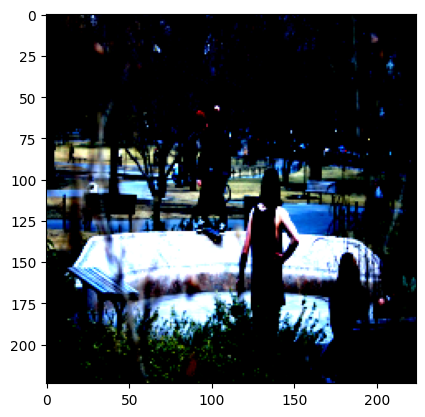

In [14]:
image, outputs, processed_image = trained_model.generate(v['image'], [v['question']], max_text_length=5)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ elephant] Confidence: 0.031214606016874313
Next token: [ elephant] Confidence: 0.2787053883075714
Next token: [ elephant] Confidence: 0.10119682550430298
Next token: [ k] Confidence: 0.06824155896902084
Next token: [ite] Confidence: 0.9110170602798462
What is the ramp made of? <|endoftext|> elephant elephant elephant kite


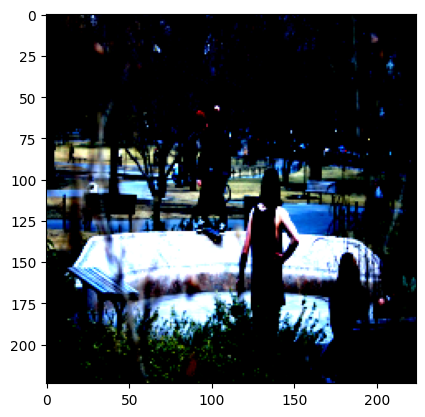

In [15]:
image, outputs, processed_image = trained_model_0.generate(v['image'], [v['question']], max_text_length=5)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [
] Confidence: 0.056261491030454636
Next token: [The] Confidence: 0.03861980140209198
Next token: [ first] Confidence: 0.010449621826410294
Next token: [ thing] Confidence: 0.06535092741250992
Next token: [ you] Confidence: 0.25447943806648254
What is the ramp made of? <|endoftext|>
The first thing you


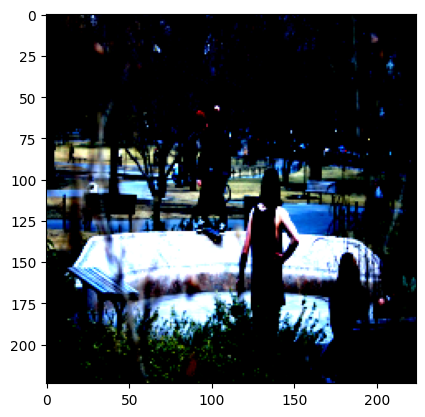

In [16]:
image, outputs, processed_image = trained_model_1.generate(v['image'], [v['question']], max_text_length=5)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ blue] Confidence: 0.008887539617717266
Next token: [prints] Confidence: 0.21993373334407806
Next token: [ are] Confidence: 0.29737016558647156
Next token: [ blue] Confidence: 0.8969182968139648
Next token: [prints] Confidence: 0.9999845027923584
What is the ramp made of? <|endoftext|> blueprints are blueprints


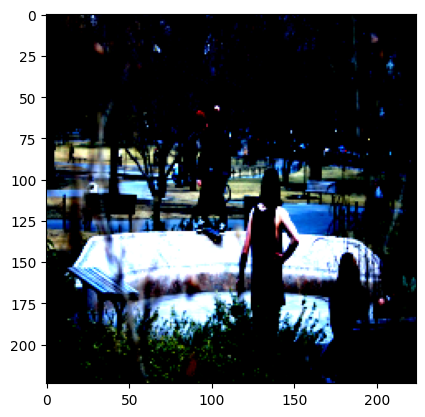

In [17]:
image, outputs, processed_image = trained_model_2.generate(v['image'], [v['question']], max_text_length=5)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/50 [00:00<?, ?it/s]

Next token: [ no] Confidence: 0.05225413665175438
Next token: [ one] Confidence: 0.25966304540634155
Next token: [ is] Confidence: 0.1570807844400406
Next token: [ no] Confidence: 0.2758719027042389
Next token: [ one] Confidence: 0.9992423057556152
Next token: [ is] Confidence: 0.9920231103897095
Next token: [ no] Confidence: 0.9996745586395264
Next token: [ one] Confidence: 0.9999492168426514
Next token: [ is] Confidence: 0.998221218585968
Next token: [ no] Confidence: 0.9999508857727051
Next token: [ one] Confidence: 0.9999731779098511
Next token: [ is] Confidence: 0.9990212917327881
Next token: [ no] Confidence: 0.9999692440032959
Next token: [ one] Confidence: 0.9999771118164062
Next token: [ is] Confidence: 0.9990214109420776
Next token: [ no] Confidence: 0.9999629259109497
Next token: [ one] Confidence: 0.9999744892120361
Next token: [ is] Confidence: 0.99918133020401
Next token: [ no] Confidence: 0.9999566078186035
Next token: [ one] Confidence: 0.9999707937240601
Next token: [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ one] Confidence: 0.9999799728393555
what sport is this person playing? <|endoftext|> no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one is no one


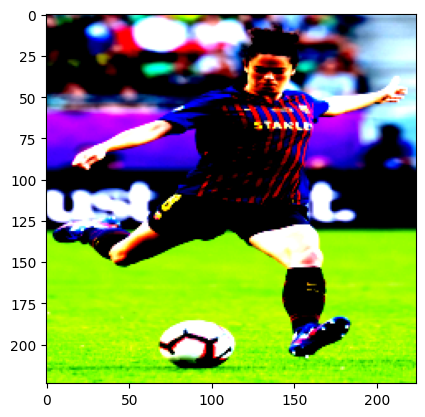

In [18]:
image, outputs, processed_image = trained_model.generate(
    'https://upload.wikimedia.org/wikipedia/commons/2/2d/2019-05-18_Fu%C3%9Fball%2C_Frauen%2C_UEFA_Women%27s_Champions_League%2C_Olympique_Lyonnais_-_FC_Barcelona_StP_1192_LR10_by_Stepro%28Cropped%29.jpg', 
    ['what sport is this person playing?'], max_text_length=50)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/50 [00:00<?, ?it/s]

Next token: [ tennis] Confidence: 0.18536277115345
Next token: [ racket] Confidence: 0.9650758504867554
Next token: [ tennis] Confidence: 0.2500280439853668
Next token: [ racket] Confidence: 0.9704222083091736
Next token: [ tennis] Confidence: 0.23504240810871124
Next token: [ racket] Confidence: 0.945160448551178
Next token: [ tennis] Confidence: 0.511142909526825
Next token: [ racket] Confidence: 0.9499088525772095
Next token: [ tennis] Confidence: 0.6148805618286133
Next token: [ racket] Confidence: 0.9609323740005493
Next token: [ tennis] Confidence: 0.6719197034835815
Next token: [ racket] Confidence: 0.963974118232727
Next token: [ tennis] Confidence: 0.7073190212249756
Next token: [ racket] Confidence: 0.9634277820587158
Next token: [ tennis] Confidence: 0.7370514869689941
Next token: [ racket] Confidence: 0.9630393385887146
Next token: [ tennis] Confidence: 0.7594252228736877
Next token: [ racket] Confidence: 0.962219774723053
Next token: [ tennis] Confidence: 0.775085031986236

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ racket] Confidence: 0.9648733735084534
what sport is this person playing? <|endoftext|> tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket tennis racket


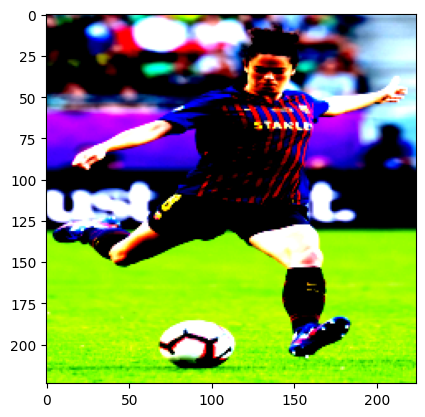

In [19]:
image, outputs, processed_image = trained_model_0.generate(
    'https://upload.wikimedia.org/wikipedia/commons/2/2d/2019-05-18_Fu%C3%9Fball%2C_Frauen%2C_UEFA_Women%27s_Champions_League%2C_Olympique_Lyonnais_-_FC_Barcelona_StP_1192_LR10_by_Stepro%28Cropped%29.jpg', 
    ['what sport is this person playing?'], max_text_length=50)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/50 [00:00<?, ?it/s]

Next token: [
] Confidence: 0.05205998569726944
Next token: [The] Confidence: 0.0387626551091671
Next token: [ first] Confidence: 0.010447663255035877
Next token: [ time] Confidence: 0.06204405799508095
Next token: [ I] Confidence: 0.4591514468193054
Next token: [ saw] Confidence: 0.17831522226333618
Next token: [ the] Confidence: 0.10506557673215866
Next token: [ movie] Confidence: 0.01671394146978855
Next token: [ "] Confidence: 0.10512059181928635
Next token: [The] Confidence: 0.10280267894268036
Next token: [ Hunger] Confidence: 0.038442712277173996
Next token: [ Games] Confidence: 0.9988541603088379
Next token: ["] Confidence: 0.6109870076179504
Next token: [ was] Confidence: 0.36081376671791077
Next token: [ in] Confidence: 0.20812755823135376
Next token: [ 2009] Confidence: 0.041583284735679626
Next token: [.] Confidence: 0.40566641092300415
Next token: [ It] Confidence: 0.22802779078483582
Next token: [ was] Confidence: 0.6207506656646729
Next token: [ a] Confidence: 0.15560863

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [ a] Confidence: 0.3576087951660156
Next token: [ very] Confidence: 0.5428997278213501
Next token: [ different] Confidence: 0.9890064001083374
what sport is this person playing? <|endoftext|>
The first time I saw the movie "The Hunger Games" was in 2009. It was a very different movie than the one I saw in 2009. It was a very different movie than the one I saw in 2009. It was a very different


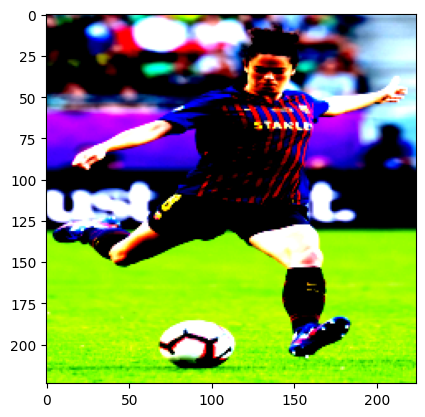

In [20]:
image, outputs, processed_image = trained_model_1.generate(
    'https://upload.wikimedia.org/wikipedia/commons/2/2d/2019-05-18_Fu%C3%9Fball%2C_Frauen%2C_UEFA_Women%27s_Champions_League%2C_Olympique_Lyonnais_-_FC_Barcelona_StP_1192_LR10_by_Stepro%28Cropped%29.jpg', 
    ['what sport is this person playing?'], max_text_length=50)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/50 [00:00<?, ?it/s]

Next token: [ blue] Confidence: 0.00914193969219923
Next token: [prints] Confidence: 0.2541756331920624
Next token: [ are] Confidence: 0.30376508831977844
Next token: [ blue] Confidence: 0.8917262554168701
Next token: [prints] Confidence: 0.9999856948852539
Next token: [ are] Confidence: 0.762281596660614
Next token: [ blue] Confidence: 0.9984726309776306
Next token: [prints] Confidence: 0.999984622001648
Next token: [ are] Confidence: 0.9925261735916138
Next token: [ blue] Confidence: 0.9993676543235779
Next token: [prints] Confidence: 0.9999936819076538
Next token: [ are] Confidence: 0.9999148845672607
Next token: [ blue] Confidence: 0.9996923208236694
Next token: [prints] Confidence: 0.9999934434890747
Next token: [ are] Confidence: 0.9999608993530273
Next token: [ blue] Confidence: 0.9998527765274048
Next token: [prints] Confidence: 0.9999911785125732
Next token: [ are] Confidence: 0.9999583959579468
Next token: [ blue] Confidence: 0.999927282333374
Next token: [prints] Confidence:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: [prints] Confidence: 0.9998730421066284
Next token: [ are] Confidence: 0.9998010993003845
Next token: [ blue] Confidence: 0.9999961853027344
Next token: [prints] Confidence: 0.9998562335968018
what sport is this person playing? <|endoftext|> blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints are blueprints


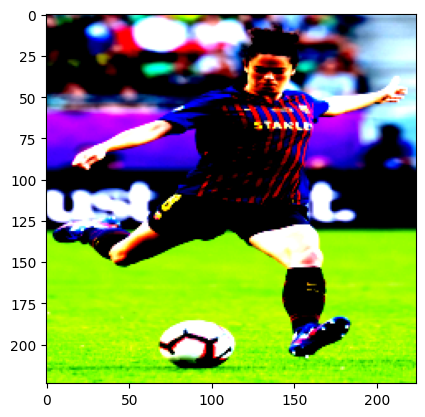

In [21]:
image, outputs, processed_image = trained_model_2.generate(
    'https://upload.wikimedia.org/wikipedia/commons/2/2d/2019-05-18_Fu%C3%9Fball%2C_Frauen%2C_UEFA_Women%27s_Champions_League%2C_Olympique_Lyonnais_-_FC_Barcelona_StP_1192_LR10_by_Stepro%28Cropped%29.jpg', 
    ['what sport is this person playing?'], max_text_length=50)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))